In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run: pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import sys
import matplotlib.ticker as mticker

sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
sns.set_style("darkgrid")

In [3]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.3.0 
xwmb version 0.2.1


In [4]:
import sectionate
print(f"Sectionate version: {sectionate.__version__}")

Sectionate version: 0.2.1


In [5]:
from Streamfunctions import *

rho0 = 1035. # kg/m3
Sv_s_per_m3 = 1e-6
Sv_s_per_kg = Sv_s_per_m3/rho0

In [6]:
def get_transports(ds):
    return ds[["umo", "vmo", "sigma2_i", "thkcello"]]

def get_zonal_avg(ds, var):
    weights = ds["thkcello"]
    avg = (ds[var] * weights).sum("xh") / weights.sum("xh")
    return avg.where(weights.sum("xh") < 0)

In [7]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x
ds = xr.open_mfdataset(
        datadir("model/CM4Xp125_budgets_sigma2_2020-2024.zarr"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")
ds = ds.fillna(0.0)

In [8]:
psi = compute_streamfunction(ds, 
                       z_coord = "sigma2_l", 
                       reverse_cumsum = True)

psi = psi.compute()

In [75]:
psi_z = get_zonal_avg(ds.mean("time"), "z").compute()

In [79]:
psi_z_ctrl = psi_z.T.sel(exp = "control").values
wherena = np.isnan(psi_z_ctrl)
psi_z_ctrl[wherena] = 1000

In [88]:
psi_ctrl = (1e-6 * psi.mean("time")).sel(exp = "control")[:, :-1]
psi_ctrl.values[wherena] = np.nan

In [89]:
LAT, sig = np.meshgrid(psi_ctrl.geolat, psi_ctrl.sigma2_l)

/tmp/ipykernel_145715/2529917349.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(LAT, psi_z_ctrl, psi_ctrl, vmin = -40, vmax = 40, cmap = "bwr")


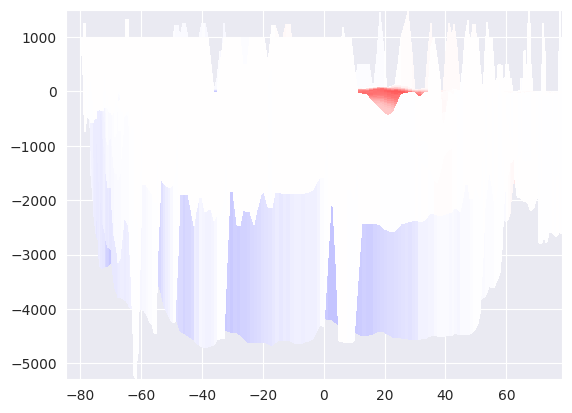

In [90]:
fig, ax = plt.subplots(sharey = True)
ax.pcolormesh(LAT, psi_z_ctrl, psi_ctrl, vmin = -40, vmax = 40, cmap = "bwr")

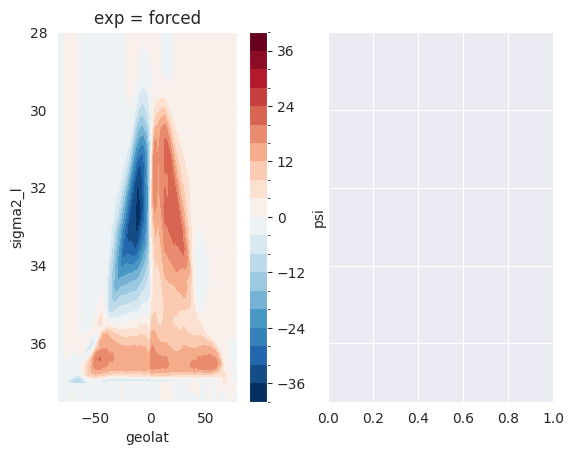

In [91]:
fig, ax = plt.subplots(1, 2, sharey = True)
levels = np.arange(-40, 41, 2)
(1e-6 * psi.mean("time")).isel(exp = 0).plot.contourf(x = "geolat", y = "sigma2_l", ax = ax[0], levels = 25)
# sectionate_psi.mean('year').isel(exp = 0).plot.contourf(x = "lat", y = "sigma2_l", ax = ax[1], levels = 25)

ax[0].set_ylim(28, 37.5)
ax[0].invert_yaxis()

In [17]:
ds_mean = get_transports(ds).mean("time").compute()
grid = CM4Xutils.ds_to_grid(ds_mean, Zprefix = "sigma2")

In [20]:
moc_indices = generate_moc_grid_indices_optimized(grid, dlat=1.)

Processing latitudes:  99%|█████████▉| 176/178 [03:43<00:02,  1.24s/lat]/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/sectionate/section.py:517: RuntimeWarning: invalid value encountered in scalar divide
  return np.arccos(np.clip((np.cos(a) - np.cos(b)*np.cos(c))/(np.sin(b)*np.sin(c)), -1., 1.))
Processing latitudes: 100%|██████████| 178/178 [03:45<00:00,  1.27s/lat]


In [21]:
ds_mean = get_transports(ds).groupby("time.year").mean("time").compute()
grid = CM4Xutils.ds_to_grid(ds_mean, Zprefix = "sigma2")

In [42]:
%time sectionate_psi = global_moc_dask(grid, moc_indices) * Sv_s_per_kg

-85.0
-80.0
-75.0
-70.0
-65.0
-60.0
-55.0
-50.0
-45.0
-40.0
-35.0
-30.0
-25.0
-20.0
-15.0
-10.0
-5.0
0.0
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
CPU times: user 29.2 s, sys: 511 ms, total: 29.7 s
Wall time: 29.8 s


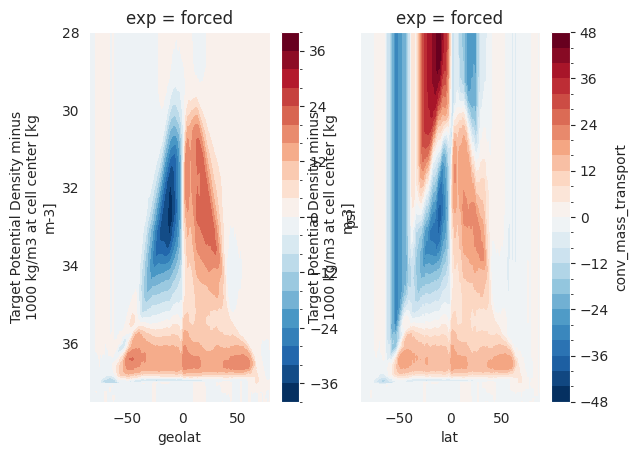

In [43]:
fig, ax = plt.subplots(1, 2, sharey = True)
levels = np.arange(-40, 41, 2)
(1e-6 * psi.mean("time")).isel(exp = 0).plot.contourf(x = "geolat", y = "sigma2_l", ax = ax[0], levels = 25)
sectionate_psi.mean('year').isel(exp = 0).plot.contourf(x = "lat", y = "sigma2_l", ax = ax[1], levels = 25)

ax[0].set_ylim(28, 37.5)
ax[0].invert_yaxis()

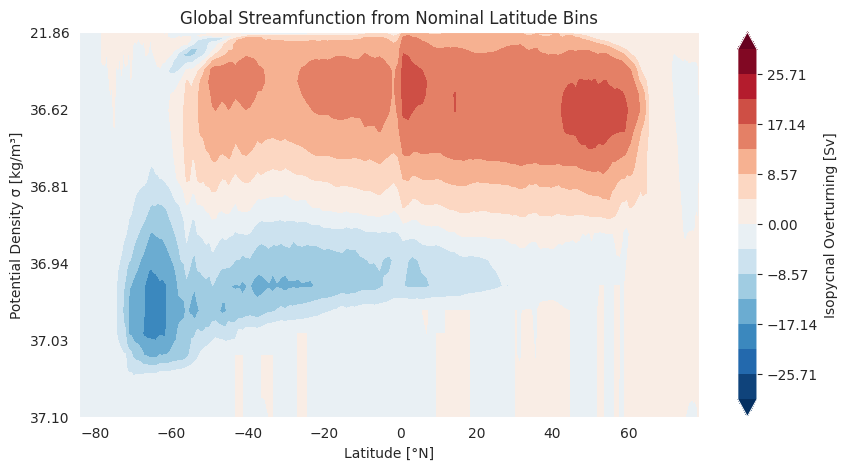

In [44]:
# If your variables have different names

psi_crop =  1e-6 * psi.mean("time").sel(sigma2_l = slice(20, 37.1))
# psi_crop = 1e-6 * psi_crop.where(np.abs(psi_crop) > 1).fillna(0.0)

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

levels = np.linspace(-30, 30, 15)

plot_isopycnal_overturning(fig, ax, 
    psi_crop.isel(exp = 1),
    streamfunction_var='psi',  # Your streamfunction variable name
    density_dim='sigma2_l',           # Your density dimension name
    lat_dim='geolat',                  # Your latitude dimension name
    power = 50,
    levels = levels
)
ax.set_title("Global Streamfunction from Nominal Latitude Bins")
ax.invert_yaxis()

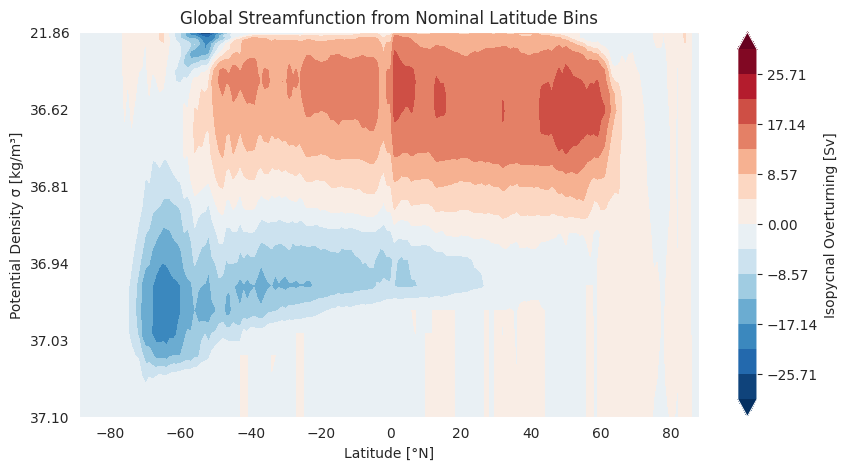

In [45]:
# If your variables have different names

psi_crop =  sectionate_psi.mean("year").sel(sigma2_l = slice(20, 37.1))
# psi_crop = 1e-6 * psi_crop.where(np.abs(psi_crop) > 1).fillna(0.0)

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

levels = np.linspace(-30, 30, 15)

plot_isopycnal_overturning(fig, ax, 
    psi_crop.isel(exp = 1).T,
    density_dim='sigma2_l',           # Your density dimension name
    lat_dim='lat',                  # Your latitude dimension name
    power = 50,
    levels = levels
)
ax.set_title("Global Streamfunction from Nominal Latitude Bins")
ax.invert_yaxis()

In [46]:
psi_yearly = psi.groupby("time.year").mean("time")
psi_yearly = psi_yearly.sel(sigma2_l = slice(36, 37.1))

In [47]:
locs = find_min_locations(psi_yearly.isel(exp = 1), fixed_dim = "year")
locs["geolat"] = 0 * locs["yq"]
locs["geolat"].values = psi_yearly["geolat"].sel(yq = locs["yq"]).values
nom_locs = locs["geolat"]

Text(0.5, 1.0, 'Maximum Abyssal Overturning (located at 67°S and sigma2 = 37)')

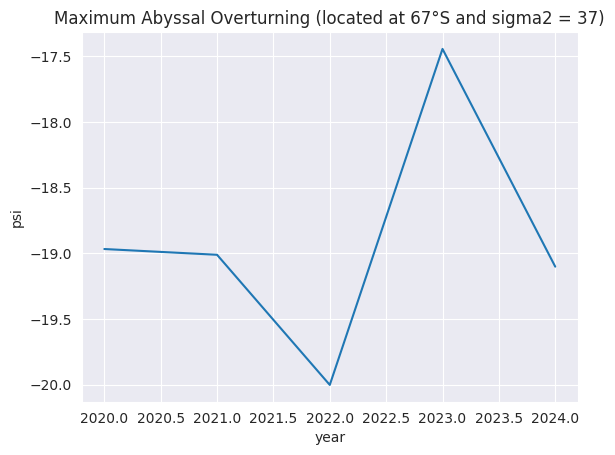

In [48]:
locs = find_min_locations(psi_yearly.isel(exp = 1).mean("year"))

fig, ax = plt.subplots()
(1e-6 * psi_yearly).isel(exp = 1).sel(locs).plot(ax = ax)
ax.set_title("Maximum Abyssal Overturning (located at 67°S and sigma2 = 37)")

In [54]:
locs = find_min_locations(sectionate_psi.sel(sigma2_l = slice(36, 37.1)).isel(exp = 1), fixed_dim = "year")

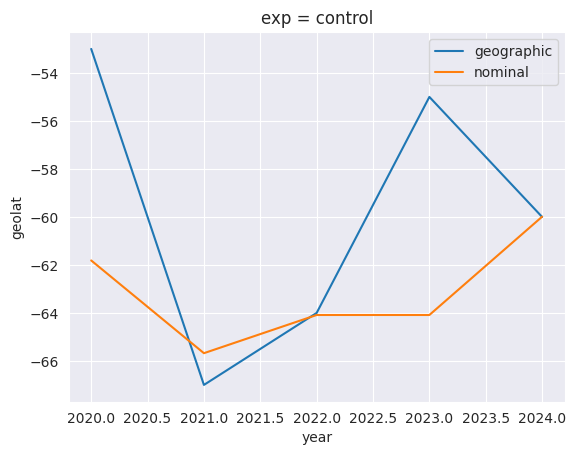

In [55]:
locs["lat"].plot(label = "geographic")
nom_locs.plot(label = "nominal")
plt.legend()